In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib.ticker import FuncFormatter

### train.csv
Здесь приведу описание полей датасета, как из оригинального испытания, так и выводы, полученные во время подготовки.

- **row_id: (int64)** ID строки
- **timestamp: (int64)** время в миллисекундах между соответствующим действием пользователя и первым завершением события для этого пользователя (эквивалент продолжительности существования пользователя на сервере)
- **user_id: (int32)** ID пользователя
- **content_id: (int16)** ID учебной единицы (леции + вопросы)
- **content_type_id: (int8)** тип учебной единицы: 0 - вопрос, 1 - лекция
- **task_container_id: (int16)** ID учебного контейнера - может состоять из нескольких вопросов и лекций, т.е. объединять несколько content_id. Вопросы считаются из одного контейнера, если объяснение дается после этого контейнера сразу на все.
- **user_answer: (int8)** значение ответа пользователя на вопрос: 0,1,2,3, для лекий  = -1
- **answered_correctly: (int8)** ответил верно = 1, неверно = 0, для лекций = -1
- **prior_question_elapsed_time: (float32)** среднее время, которое пользователь потратил, чтобы ответить на каждый вопрос в предыдущем контейнере, не учитывая лекции
- **prior_question_had_explanation: (bool)** видел ли пользователь объяснение и правильный ответ на предыдущий блок вопросов, одно значение на весь контейнер

In [139]:
#Создаю конвертеры, позволяющие уменьшить объем занимаемой памяти, чтобы применить при скачивании всего файла.
# Информация об оптимальном типе колонок указана в описании датасета 
train = pd.read_csv('./sets/train.csv',
                    dtype ={'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'boolean',
                            'task_container_id':'int16',
                            'user_answer':'int8',
                            'answered_correctly':'int8',
                            'prior_question_elapsed_time':'float32',
                            }
                    )

In [140]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499999 entries, 0 to 499998
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          499999 non-null  int64  
 1   timestamp                       499999 non-null  int64  
 2   user_id                         499999 non-null  int32  
 3   content_id                      499999 non-null  int16  
 4   content_type_id                 499999 non-null  boolean
 5   task_container_id               499999 non-null  int16  
 6   user_answer                     499999 non-null  int8   
 7   answered_correctly              499999 non-null  int8   
 8   prior_question_elapsed_time     488372 non-null  float32
 9   prior_question_had_explanation  498253 non-null  object 
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 19.1+ MB


In [141]:
train.nunique()

row_id                            499999
timestamp                         385220
user_id                             1749
content_id                         13120
content_type_id                        2
task_container_id                   7740
user_answer                            5
answered_correctly                     3
prior_question_elapsed_time         1384
prior_question_had_explanation         2
dtype: int64

Сколько существует уникальных лекций и вопросов?

In [142]:

print(f'{train["content_id"].nunique()} уникальных идентификаторов контента, из которых {train[train.content_type_id == False]["content_id"].nunique()} - это вопросы')
print(f'{train.task_container_id.nunique()} уникальных контейнеров')

13120 уникальных идентификаторов контента, из которых 12883 - это вопросы
7740 уникальных контейнеров


Давайте рассмотрим какие вопросы встречались чаще всего:

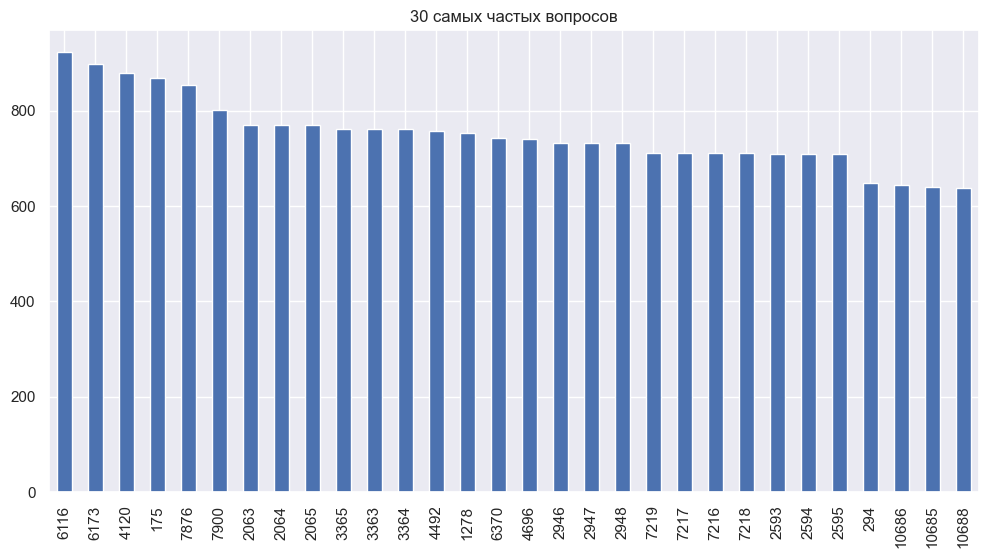

In [143]:
qids = train[train.content_type_id==0].content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = qids.plot.bar()
plt.title("30 самых частых вопросов")
plt.xticks(rotation=90)
plt.show()

Рассмотрим распределение продолжительности жизни пользователя.

Прикинем, сколько в месяцах можно измерить самое продолжительное пребывание:

In [144]:
train['timestamp'].max()/(31536000000/12)

29.715371596651448

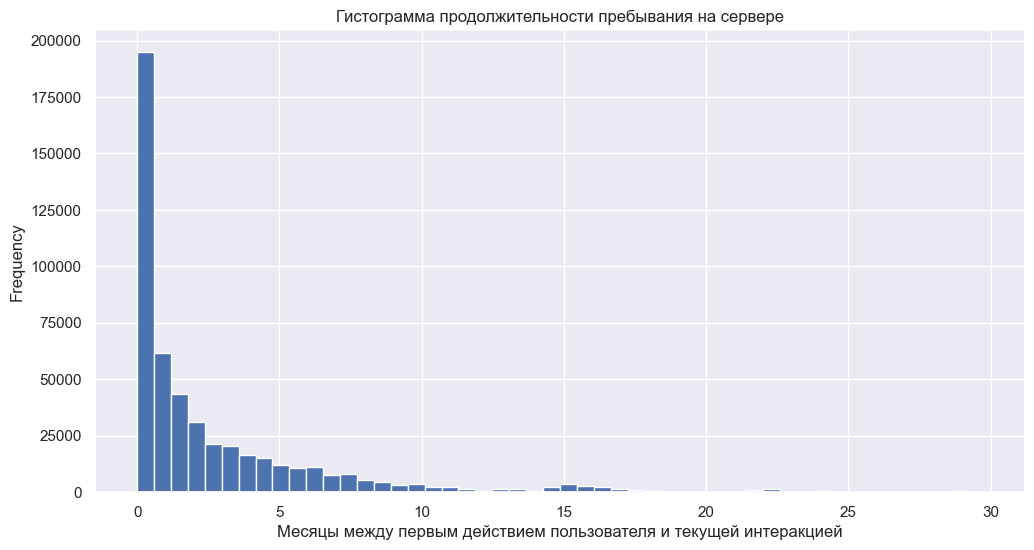

In [145]:
#1 год = 31536000000 мс
ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=50)
plt.title("Гистограмма продолжительности пребывания на сервере")
plt.xticks(rotation=0)
plt.xlabel("Месяцы между первым действием пользователя и текущей интеракцией")
plt.show()

 По этому графику нельзя определить ушел ли пользователь, или еще "молод". 

Давайте узнаем как далеко прошел каждый пользователь:

<Figure size 1200x600 with 0 Axes>

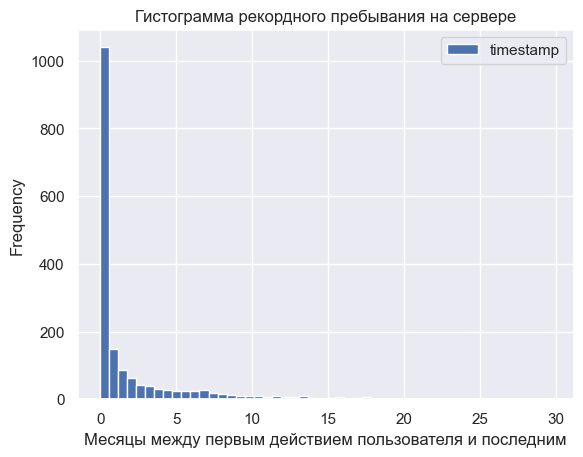

In [146]:
#1 год = 31536000000 мс
ts = train.groupby('user_id').agg({'timestamp': 'max'})/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=50)
plt.title("Гистограмма рекордного пребывания на сервере")
plt.xticks(rotation=0)
plt.xlabel("Месяцы между первым действием пользователя и последним")
plt.show()

Видим, что значительная часть - новички, однако есть заметное количество студентов, преодолевших порог в 5 месяцев

Как часто на вопросы отвечают верно?

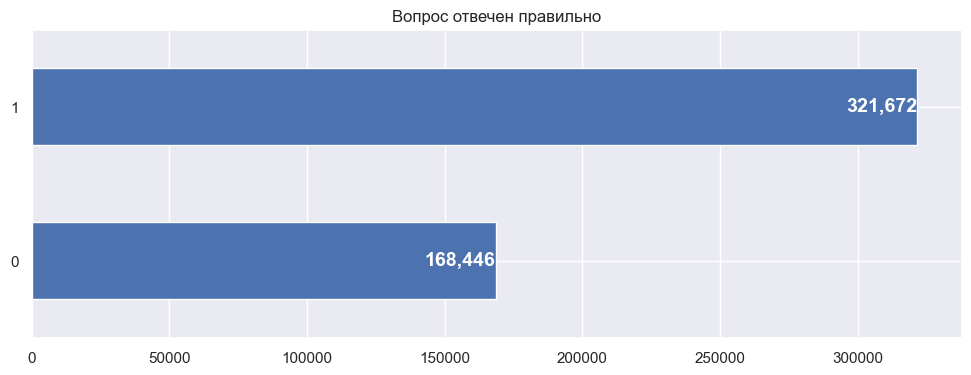

In [147]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Вопрос отвечен правильно")
plt.xticks(rotation=0)
plt.show()

На вопросы, которые встречаются позже по курсу, отвечают только долго пребывающие на сервере пользователи. Интересно проверить, чаще ли на эти вопросы дают правильный ответ?  

In [148]:
# эта функция создает сводную таблицу относительно корректности ответа, отсекая лекции и нормализуя значения подаваемой колонки  
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

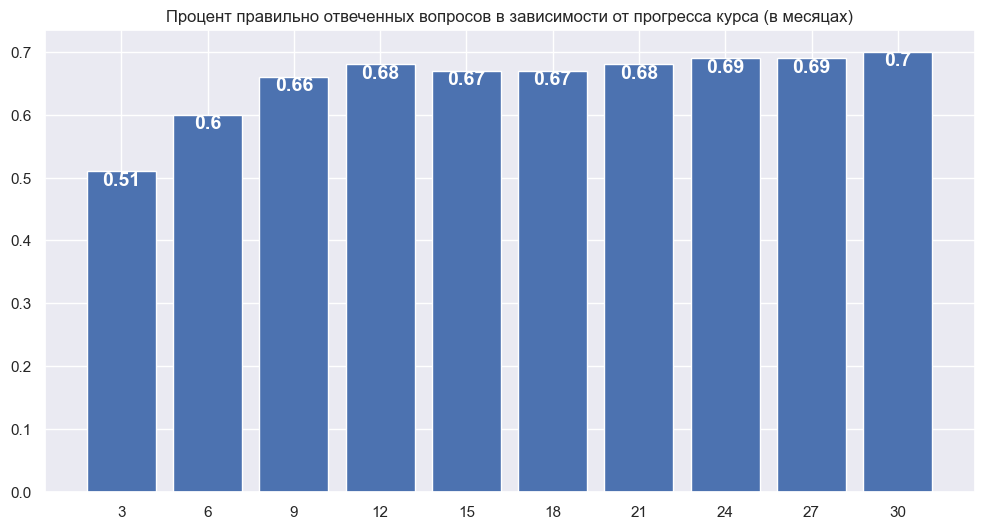

In [149]:
# разбиваю продолжительность жизни на чанки по 3 месяца
bin_labels_10 = ['3', '6', '9', '12', '15', '18', '21', '24', '27', '30']

# разделю датасет по этим чанкам
train['ts_bin'] = pd.qcut(train['timestamp'], q=10, labels=bin_labels_10)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент правильно отвеченных вопросов в зависимости от прогресса курса (в месяцах)")
plt.xticks(rotation=0)
plt.show()

Как видно, вопросы, которые встретились позже по курсу, в относительном значении чаще были отвечены правильно. Однако, стоит отметить, что количество раз, когда такой вопрос задавался значительно меньше.

Изучим теперь, как мог повлиять просмотр правильного решения на предыдуший вопрос. Для начала оценим качество данных:

In [150]:
train[train['prior_question_had_explanation'].isna()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,ts_bin
0,0,0,115,5692,False,1,3,1,NaN,NaN,3
46,46,0,124,7900,False,0,0,1,NaN,NaN,3
76,76,0,2746,5273,False,0,1,0,NaN,NaN,3
96,96,0,5382,5000,False,0,0,1,NaN,NaN,3
224,224,0,8623,3915,False,0,3,1,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
499260,499260,0,9660056,6141,False,0,1,1,NaN,NaN,3
499287,499287,0,9665071,7900,False,0,0,1,NaN,NaN,3
499322,499322,0,9666467,7900,False,0,0,1,NaN,NaN,3
499352,499352,0,9669185,3974,False,0,0,1,NaN,NaN,3


Понятно, что для каждого пользователя перед первым вопросом значение **prior_question_had_explanation** будет отсутствовать. 
Заменим его на числовое, чтобы впоследствии было проще с ним работать

In [151]:
train["prior_question_had_explanation"].fillna(value = -1, inplace = True)


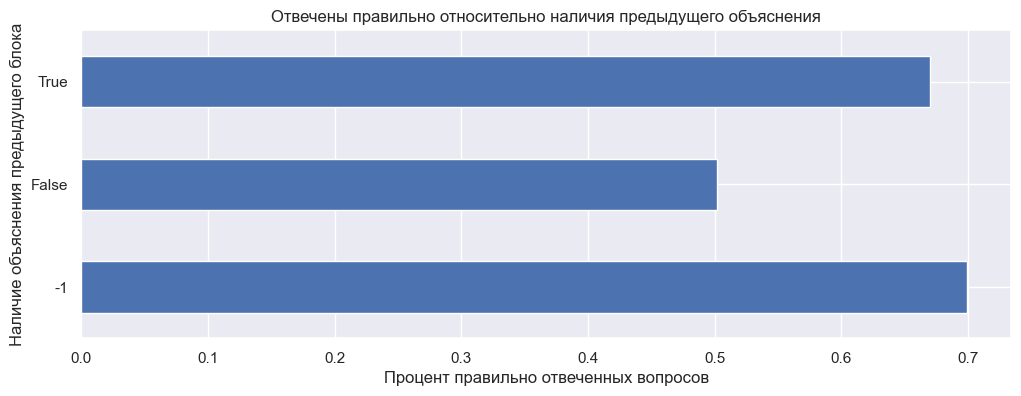

In [152]:
# аггрегируем среднее и общее количество по группе предыдущего объяснения для всех не лекций
prior_exp = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation']).agg({'answered_correctly': ['mean', 'count']})

prior_exp_perc = prior_exp.iloc[:,0]

fig = plt.figure(figsize=(12,4))
prior_exp_perc.plot.barh()
plt.title("Отвечены правильно относительно наличия предыдущего объяснения")
plt.xlabel("Процент правильно отвеченных вопросов")
plt.ylabel("Наличие объяснения предыдущего блока")
plt.xticks(rotation=0)
plt.show()

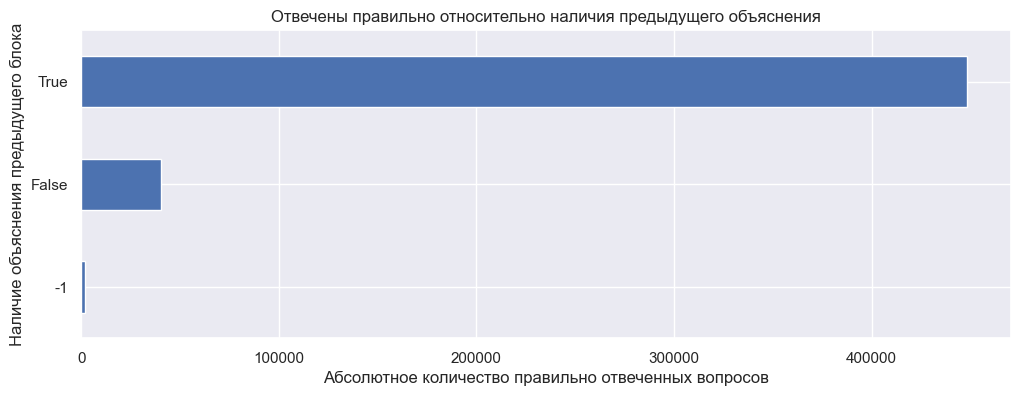

In [153]:
# аггрегируем среднее и общее количество по группе предыдущего объяснения для всех не лекций
prior_exp = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation']).agg({'answered_correctly': ['mean', 'count']})

prior_exp_abs = prior_exp.iloc[:,1]

fig = plt.figure(figsize=(12,4))
prior_exp_abs.plot.barh()

plt.title("Отвечены правильно относительно наличия предыдущего объяснения")
plt.xlabel("Абсолютное количество правильно отвеченных вопросов")
plt.ylabel("Наличие объяснения предыдущего блока")
plt.xticks(rotation=0)
plt.show()



Text(0.5, 1.0, 'Отвечены правильно относительно наличия предыдущего объяснения')

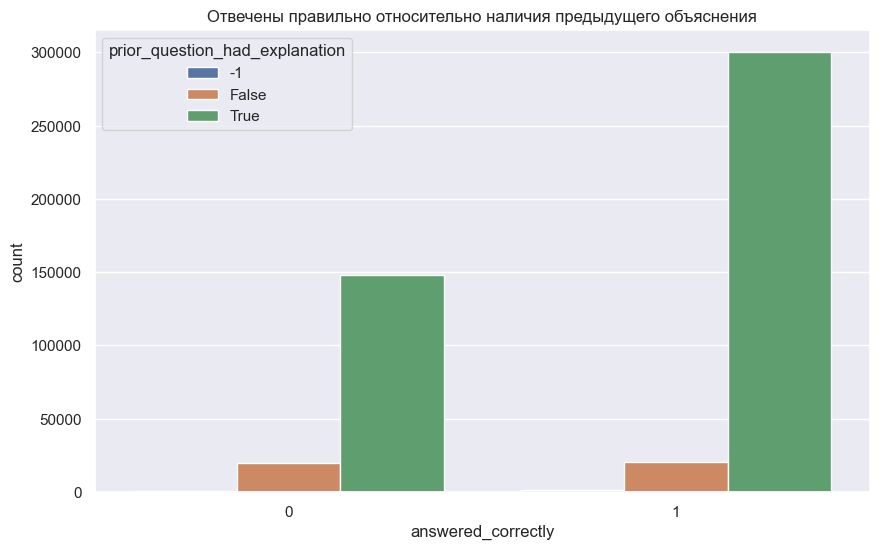

In [154]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train[train.answered_correctly != -1], x='answered_correctly', hue='prior_question_had_explanation')
plt.title('Отвечены правильно относительно наличия предыдущего объяснения')

В среднем, вопросы с ответом на предудыщий вопрос были чаще отвечены верно, но и встречались гораздо чаще. 
На первый вопрос, который не может иметь осмысленного значения prior_question_had_explanation, значительно чаще отвечали верно.

Поймем теперь связь между временем затраченным на ответ с его корректностью. Видно, что максимум отведенный на вопрос - 300 мс или 5 мин.

In [155]:
train['prior_question_elapsed_time'].describe()

count    488372.000000
mean      24860.910156
std       19170.505859
min           0.000000
25%       15667.000000
50%       21000.000000
75%       29000.000000
max      300000.000000
Name: prior_question_elapsed_time, dtype: float64

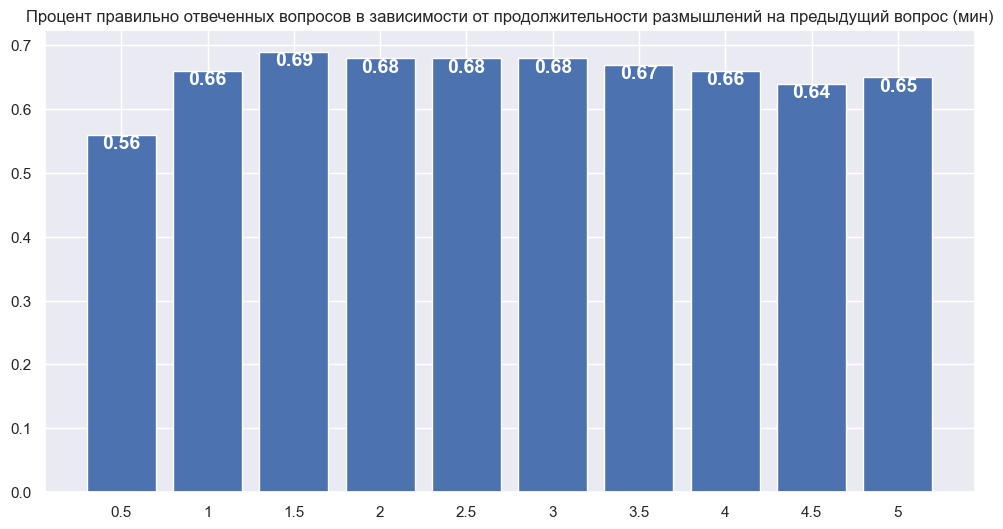

In [156]:
# разбиваю продолжительность размышлений на чанки по пол-минуты
bin_labels_5 = ['0.5', '1','1.5', '2', '2.5','3', '3.5','4','4.5', '5']

# разделю датасет по этим чанкам
train['et_bin'] = pd.qcut(train['prior_question_elapsed_time'], q=10, labels=bin_labels_5)

bins_correct = correct("et_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент правильно отвеченных вопросов в зависимости от продолжительности размышлений на предыдущий вопрос (мин)")
plt.xticks(rotation=0)
plt.show()

Подобный анализ не предлагает значительный статистический вывод. Возможно, этот параметр скажет больше при рассмотрении информации о вопросах.

### questions.csv

Метаданные о вопросах, предложенных пользователям.

**question_id**: внешний ключ к датасету train по колонке content_id, где content_type_id = 0, то есть вопрос

**bundle_id**: номер контейнера, объединяющий принадлежащие ему вопросы

**correct_answer**: правильный вариант ответа на вопрос

**part**: категория учебной единицы 

**tags**: один или несколько ярлыков для каждого вопроса, их расшифровка не предоставлена, значения могут быть использованы для кластеризации

Больше про **parts**:

Категории 1-4 соответствуют Listening Section (ок. 45 минут, 100 вопросов)  
Категории 5-7 соответствуют Reading Section (ок. 75 минут, 100 вопросов).

In [204]:
questions = pd.read_csv('./sets/questions.csv')


In [159]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Сколько всего существует независимых тагов? Бывают ли вопросы без тагов?

In [161]:
questions[questions.tags.isna()]


,question_id,bundle_id,correct_answer,part,tags


В нашей уменьшенной версии датасета не встретилось ни одного вопроса без тага.

In [205]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'{len(tags)} различных тагов')

188 различных тагов


Посчитаем, как были отвечены вопросы при различных тагах

In [206]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list

# воспользуемся функцией, созданной ранее для аггрегации по правильности ответа
correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['wrong', 'correct']
correct = correct.fillna(0)
correct[['wrong', 'correct']] = correct[['wrong', 'correct']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")

questions.head()

,question_id,bundle_id,correct_answer,part,tags,wrong,correct
0,0,0,0,1,"[51, 131, 162, 38]",5.0,34.0
1,1,1,1,1,"[131, 36, 81]",2.0,24.0
2,2,2,0,1,"[131, 101, 162, 92]",92.0,113.0
3,3,3,0,1,"[131, 149, 162, 29]",20.0,72.0
4,4,4,3,1,"[131, 5, 162, 38]",59.0,87.0


In [207]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'wrong': ['sum'], 'correct': ['sum']})
    df1['all_questions'] = df1.wrong + df1.correct
    df1['q_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['wrong', 'correct', 'all_questions']] = tags_df[['wrong', 'correct', 'all_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.correct/tags_df.all_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

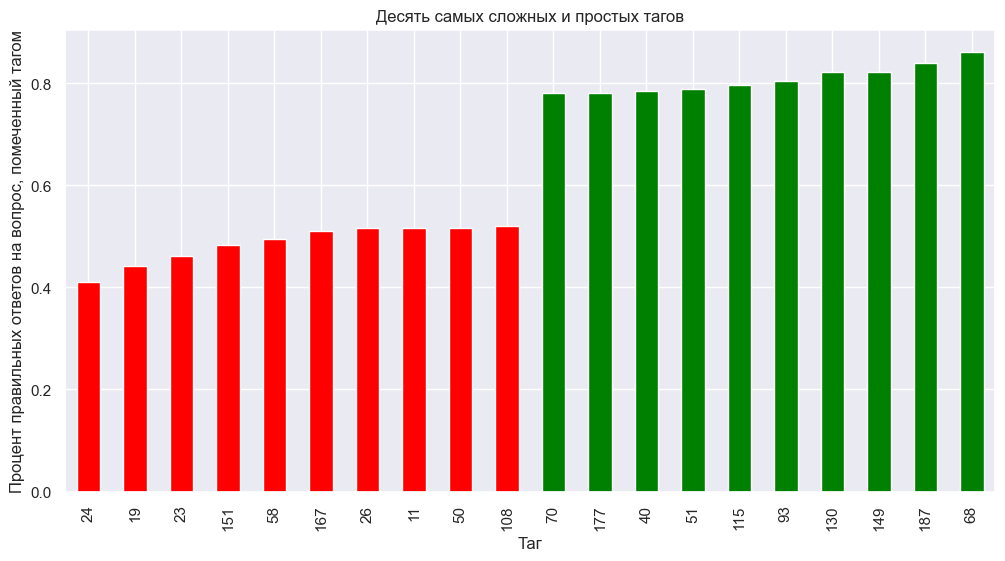

In [209]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Десять самых сложных и простых тагов")
plt.xlabel("Таг")
plt.ylabel("Процент правильных ответов на вопрос, помеченный тагом")
plt.xticks(rotation=90)
plt.show()

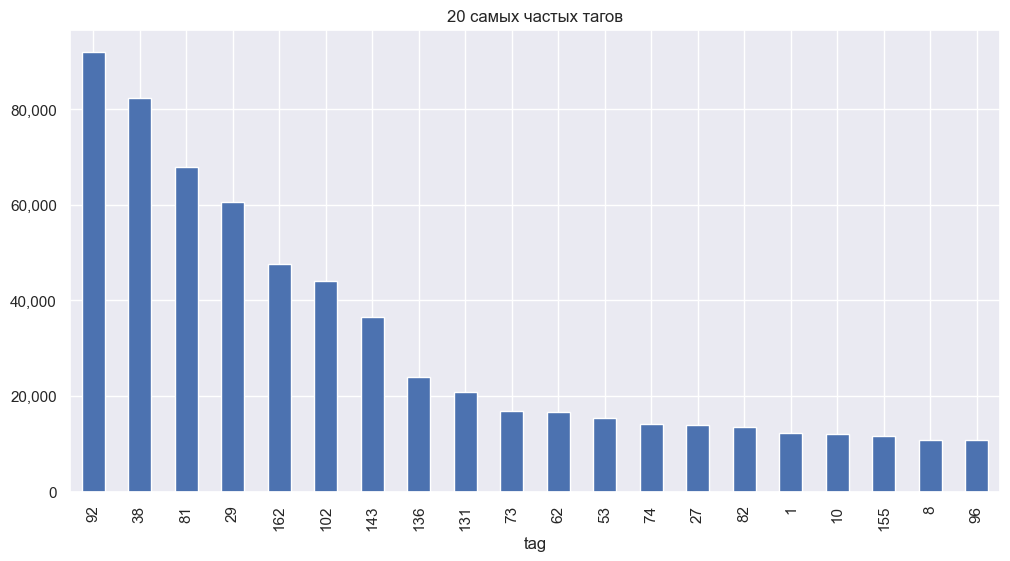

In [211]:
tags_select = tags_df.sort_values(by = "all_questions", ascending = False).iloc[:20,:]
tags_select = tags_select["all_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("20 cамых частых тагов")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

Давайте рассмотрим поле категорий вопросов:

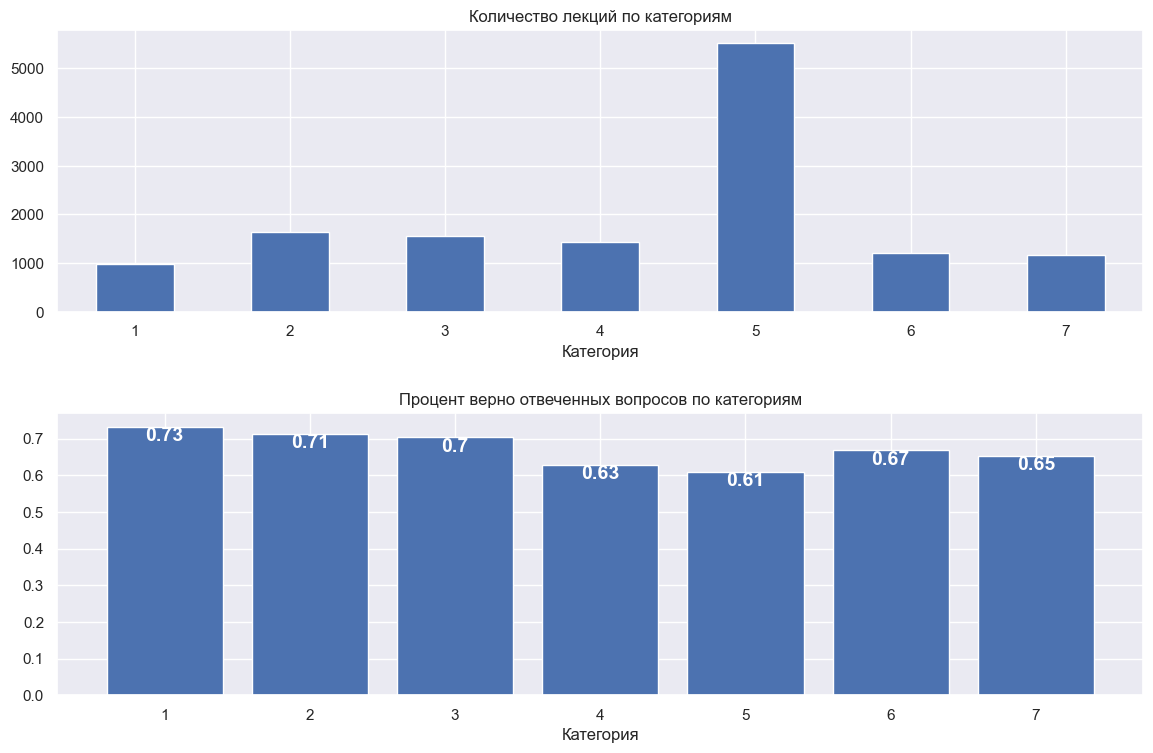

In [214]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar()
plt.title("Количество лекций по категориям")
plt.xlabel("Категория")
plt.xticks(rotation=0)

part = questions.groupby('part').agg({'wrong': ['sum'], 'correct': ['sum']})
part['Percent_correct'] = part.correct/(part.correct + part.wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("Процент верно отвеченных вопросов по категориям")
plt.xlabel("Категория")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

### lectures.csv

Метаданные о лекциях, просмотренных пользователям при продвижении по курсу.

**lecture_id:** внешний ключ к датасету train по колонке content_id, где content_type_id = 1, то есть лекция

**part:** категория лекции (1-7)

**tag:** ярлыки для лекций, их расшифровка не предоставлена, значения могут быть использованы для кластеризации

**type_of**: тип лекции - краткое описание предназначения лекции

In [87]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


Какие лекции присутствуют в датасете, как они распределены по типу?

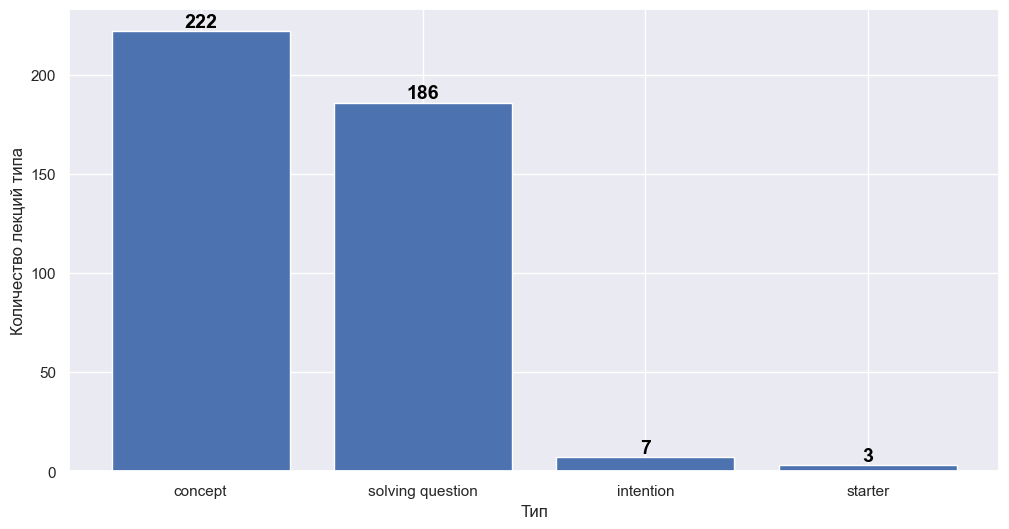

In [217]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("")
plt.xlabel("Тип")
plt.ylabel("Количество лекций типа")
plt.xticks(rotation=0)
plt.show()

Как лекции распределены по категории?

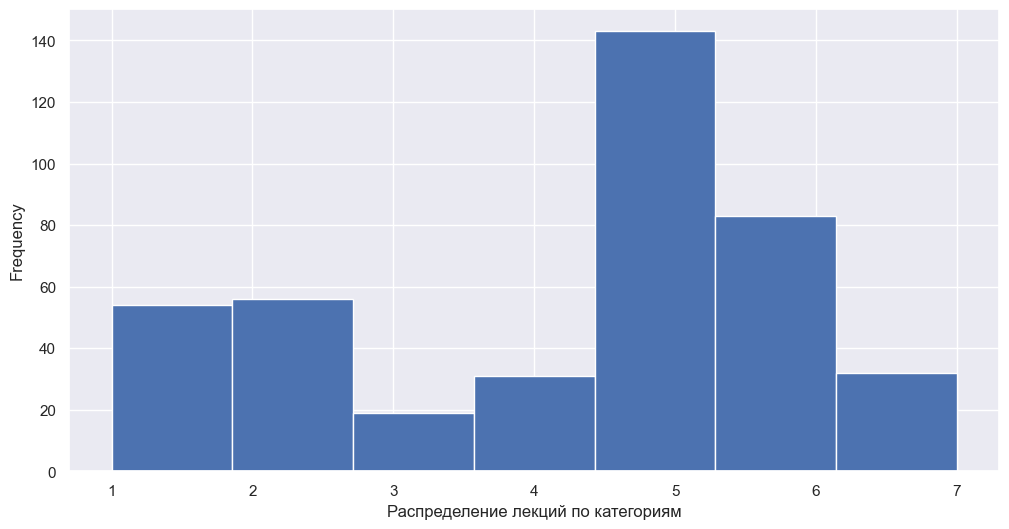

In [240]:
lp = lectures['part']
fig = plt.figure(figsize=(12,6))
lp.plot.hist(bins=7)
plt.xticks(rotation=0)
plt.xlabel("Распределение лекций по категориям")
plt.show()

False    1027
True      722
Name: watches_lecture, dtype: int64


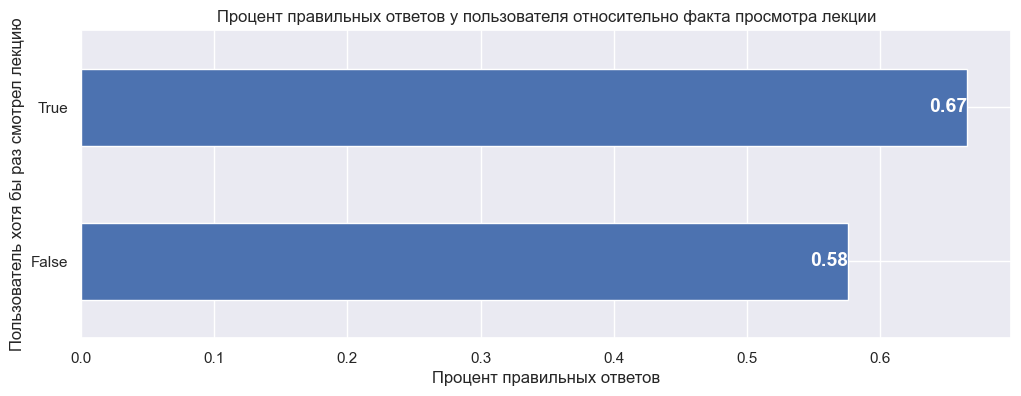

In [221]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['lecture', 'wrong', 'correct']
user_lect['Lecture'] = user_lect['lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("watches_lecture").agg({'wrong': ['sum'], 'correct': ['sum']})
print(user_lect.watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.correct/(watches_l.correct + watches_l.wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Процент правильных ответов у пользователя относительно факта просмотра лекции")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Пользователь хотя бы раз смотрел лекцию")
plt.xticks(rotation=0)
plt.show()

Можно было бы дальше развивать мысль в этом направлении, изучив влияние большего количества просмотров лекций, или просмотров лекций к текущему уроку.